# Comparison of design sequence mutations to experimentally-derived fitness measurements of individual point mutations

In [1]:
#########################
#                       #
#                       #
#    LIBRARY IMPORT     #
#                       #
#                       #
#########################

import os, re, sys
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from functools import reduce
from enum import Enum
from importlib import reload
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [2]:
#############################
#                           #
#                           #
#        LOAD DATA          #
#                           #
#                           #
#############################
LOCAL_DIR = '.'
DATA_DIR = LOCAL_DIR+'/data'
OUTPUT_DIR = LOCAL_DIR+'/figures/dms'
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

In [3]:
from importlib import reload
sys.path.append(LOCAL_DIR) #Helper Functions Here
import FramHelperScripts
reload(FramHelperScripts)
FHS = FramHelperScripts.FramHelperFunctions(DATA_DIR)

## Load Data

In [4]:
#########################
#                       #
#                       #
#       LOAD DATA       #
#                       #
#                       #
#########################
dms_df = FHS.get_dms_df()
sequences_df = FHS.get_sequences_df()

## Data Plotting

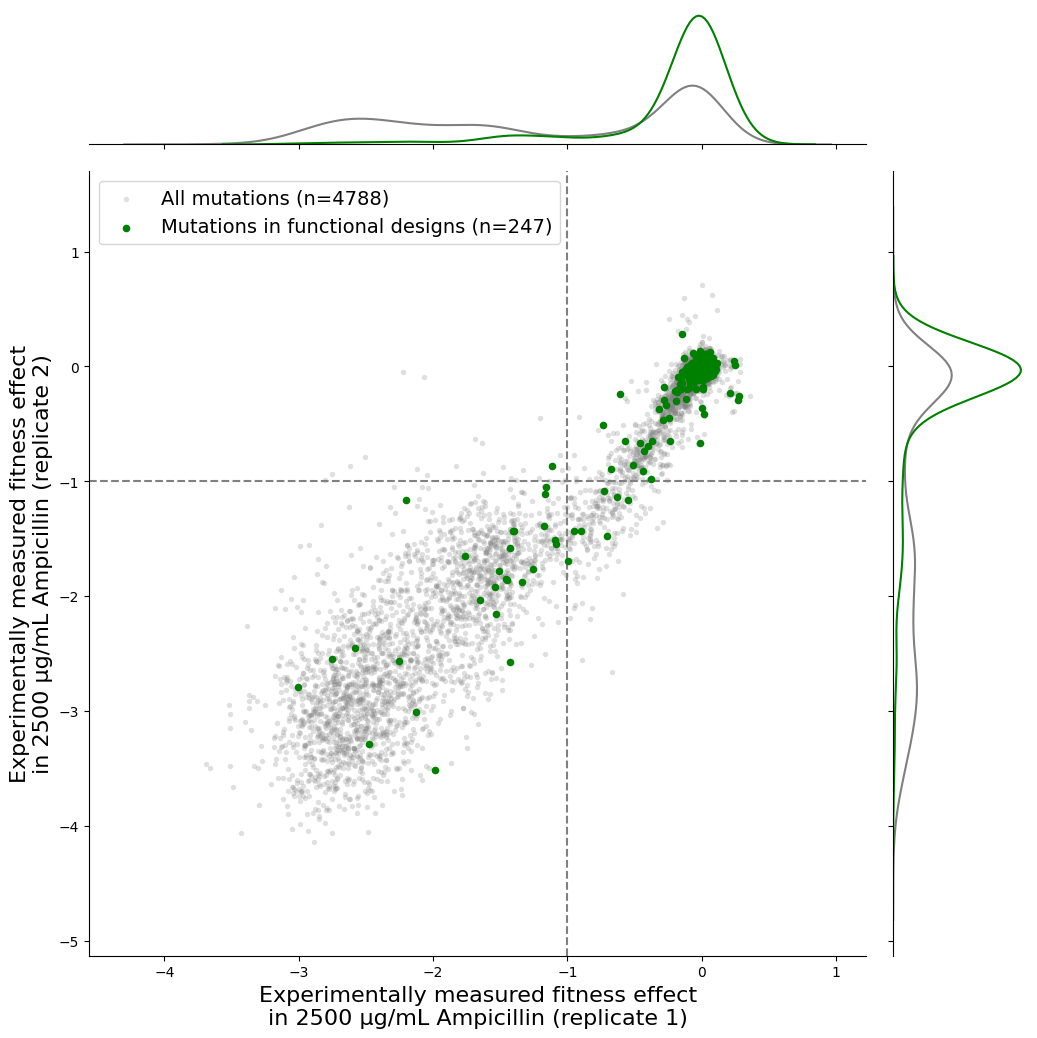

In [5]:
def plot_final_main_figure():
    all_df = dms_df[dms_df.amp_conc==2500]
    func_df = all_df[all_df.func_designs_with_mut.str.len() > 0]

    #hack to plot two datasets in the same jointplot - first plot jointplot
    jp = sns.jointplot(
        data=dms_df[dms_df.amp_conc==-1], #no data - plotted later
        x='rep1_value', y='rep2_value',
        height=10
    )

    #plot all dots and kde marginals
    jp.ax_joint.scatter(
        data=all_df, x='rep1_value', y='rep2_value',
        color='gray', alpha=0.25, s=15, linewidth=0,
        label='All mutations (n={0})'.format(len(all_df)),
    )
    sns.kdeplot(x=all_df.rep1_value, ax=jp.ax_marg_x, color='gray')
    sns.kdeplot(y=all_df.rep2_value, ax=jp.ax_marg_y, color='gray')

    #plot functional dots and kde marginals
    jp.ax_joint.scatter(
        data=func_df, x='rep1_value', y='rep2_value',
        zorder=100000, color='green', alpha=1, s=30, linewidth=0,
        label='Mutations in functional designs (n={0})'.format(len(func_df)),
    )
    sns.kdeplot(x=func_df.rep1_value, ax=jp.ax_marg_x, color='green')
    sns.kdeplot(y=func_df.rep2_value, ax=jp.ax_marg_y, color='green')

    jp.ax_joint.legend(prop={'size':14},loc='upper left')
    jp.ax_joint.set_xlabel('Experimentally measured fitness effect\nin 2500 µg/mL Ampicillin (replicate 1)', fontsize=16)
    jp.ax_joint.set_ylabel('Experimentally measured fitness effect\nin 2500 µg/mL Ampicillin (replicate 2)', fontsize=16)
    
    jp.ax_joint.axvline(x=-1, color='gray', linestyle='--')
    jp.ax_joint.axhline(y=-1, color='gray', linestyle='--')
    jp.fig.savefig(OUTPUT_DIR+'/DMS_main_final_fig.pdf')

plot_final_main_figure()

In [6]:
def get_source_data():
    tmp_df = dms_df[dms_df.amp_conc==2500].assign(
        in_func = lambda df: df.func_designs_with_mut.apply(
            lambda funcmuts: len(funcmuts) > 0
        )
    )[[
        'stiffler_mutation', 'rep1_value', 'rep2_value', 'in_func',
    ]].rename(columns={
        'stiffler_mutation': 'mutation (dms numbering)',
        'rep1_value': 'X-axis - experimentally measured fitness score - replicate 1',
        'rep2_value': 'Y-axis - experimentally measured fitness score - replicate 2',
        'in_func': 'is in functional sequence',
    }).reset_index(drop=True)
    return tmp_df
get_source_data().to_csv(OUTPUT_DIR+'/DMS_main_final_fig.tab', sep ='\t', index=False)

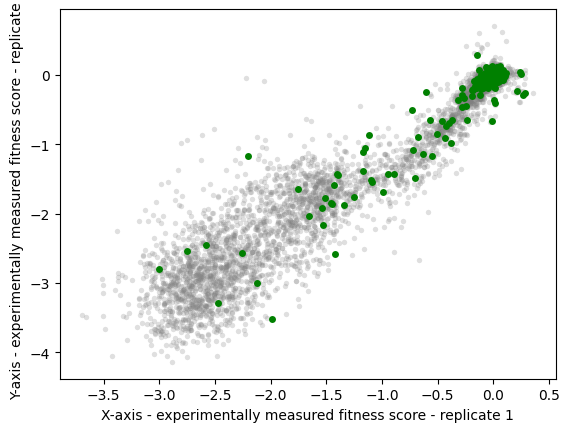

In [7]:
def test_source_data():
    tmp_df = get_source_data()
    sns.scatterplot(
        tmp_df,
        x='X-axis - experimentally measured fitness score - replicate 1',
        y='Y-axis - experimentally measured fitness score - replicate 2',
        color='gray', alpha=0.25, s=15, linewidth=0,
    )
    sns.scatterplot(
        tmp_df[tmp_df['is in functional sequence']==True],
        x='X-axis - experimentally measured fitness score - replicate 1',
        y='Y-axis - experimentally measured fitness score - replicate 2',
        color='green', alpha=1, s=25, linewidth=0,
    )
test_source_data()

## List of mutations

In [8]:
#
# List outliers that occur in at least one functional sequence
#
def collect_outliers(only_func=True):
    max_outlier_dms_value = -1

    outlier_muts_df = dms_df[(
        (dms_df.rep1_value < max_outlier_dms_value) | 
        (dms_df.rep2_value < max_outlier_dms_value)
    )]

    if only_func:
        return outlier_muts_df[
            outlier_muts_df.func_designs_with_mut.str.len() > 0
        ]
    
    return outlier_muts_df[(
        (outlier_muts_df.func_designs_with_mut.str.len() > 0) |
        (outlier_muts_df.nonfunc_designs_with_mut.str.len() > 0)
    )]

collect_outliers(only_func=True)

,stiffler_mutation,amp_conc,rep1_value,rep2_value,mut_from,stiffler_position,mut_to,model_pos,model_mutation,ctrls_with_mut,func_designs_with_mut,nonfunc_designs_with_mut
13587,I246D,156,-0.372757,-1.007299,I,246,D,243,I243D,[rw-consensus],[opt.b],[70.b]
13697,G251W,156,-0.848141,-1.477976,G,251,W,248,G248W,[rw-consensus],"[70.a, opt.b]","[50.a, 70.b]"
14250,I282A,156,-0.601011,-1.209188,I,282,A,278,I278A,[],[opt.b],[50.b]
14387,V33F,625,-1.773932,-1.839480,V,33,F,31,V31F,[],[opt.b],[]
15047,M68Y,625,-0.962782,-1.685937,M,68,Y,66,M66Y,[],[opt.b],[]
18110,F230E,625,-0.999541,-1.673494,F,230,E,228,F228E,[],[opt.b],[]
18364,G245N,625,-1.152232,-1.734437,G,245,N,242,G242N,[rw-consensus],[opt.b],"[50.b, 70.b]"
18375,I246D,625,-1.978679,-2.031231,I,246,D,243,I243D,[rw-consensus],[opt.b],[70.b]
18485,G251W,625,-1.940143,-2.435388,G,251,W,248,G248W,[rw-consensus],"[70.a, opt.b]","[50.a, 70.b]"
18774,S268D,625,-0.791693,-1.339399,S,268,D,264,S264D,[],[opt.b],[]


## Deep dive into a single point mutant

In [9]:
print('*********************************')
print('*                               *')
print('*                               *')
print('*       DEEP DIVE INTO A        *')
print('*         SINGLE KNOWN          *')
print('*     DELETERIOUS MUTATION      *')
print('*                               *')
print('*                               *')
print('*********************************')
print('PAPER: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9137480/')
print('functional variants with G251W = {0}'.format(
    list(dms_df[(
        (dms_df.stiffler_mutation=='G251W') & 
        (dms_df.amp_conc==2500)
    )].func_designs_with_mut)[0]
))
print('functional variants with G251W = {0}'.format(
    list(dms_df[(
        (dms_df.stiffler_mutation=='G251W') &
        (dms_df.amp_conc==2500)
    )].nonfunc_designs_with_mut)[0]
))

filter1 = dms_df.amp_conc == 2500
filter2 = dms_df.stiffler_mutation.isin([
    'V31A', 'V31K', 'V31M', 'V31Q', 'V31R', 'D38K', 'D38N', 'D38R', 'Q39K', 
    'A42G', 'I47V', 'E48M', 'L49M', 'L51M', 'L51T', 'N52E', 'F60C', 'F60W', 
    'F60Y', 'P62A', 'P62G', 'E63F', 'E63H', 'E63N', 'E63W', 'E63Y', 'S124E', 
    'S124D', 'E147G', 'H153R', 'N175G', 'M182A', 'M182C', 'M182F', 'M182I', 
    'M182L', 'M182S', 'M182T', 'A184L', 'A184P', 'A184V', 'E212A', 'E212M', 
    'E212S', 'G218D', 'A224A', 'A224V', 'F230K', 'R275I', 'R275T', 'R275V'
])
filter3 = dms_df.func_designs_with_mut.str.len() > 0
filter4 = dms_df.nonfunc_designs_with_mut.str.len() > 0
dms_df[filter1 & filter2 & (filter3 | filter4)]

### NOTE: Do not have 2 tawfik-described mutations (in any variant) that 
###       supposedly increase activity on Sefotaxime, but decreases evolvability.
###  paper title: Negative Epistasis and Evolvability in TEM-1 β-Lactamase--The
###               Thin Line between an Enzyme's Conformational Freedom and Disorder
#all_data.df_dms[all_data.df_dms.stiffler_mutation=='G238S']
#all_data.df_dms[all_data.df_dms.stiffler_mutation=='R164S']


*********************************
*                               *
*                               *
*       DEEP DIVE INTO A        *
*         SINGLE KNOWN          *
*     DELETERIOUS MUTATION      *
*                               *
*                               *
*********************************
PAPER: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9137480/
functional variants with G251W = ['70.a', 'opt.b']
functional variants with G251W = ['50.a', '70.b']


,stiffler_mutation,amp_conc,rep1_value,rep2_value,mut_from,stiffler_position,mut_to,model_pos,model_mutation,ctrls_with_mut,func_designs_with_mut,nonfunc_designs_with_mut
19279,D38R,2500,0.041990,0.057925,D,38,R,36,D36R,[],[opt.b],[]
19346,A42G,2500,0.053631,0.019359,A,42,G,40,A40G,[rw-consensus],"[80.a, 90.b]",[]
19528,L51T,2500,-0.461156,-0.670903,L,51,T,49,L49T,[],"[70.a, 80.b, opt.b]",[70.b]
19683,F60Y,2500,-0.073284,0.032458,F,60,Y,58,F58Y,[rw-consensus],"[70.a, 80.a, 80.b, 90.a, 90.b, 95.a, 95.b, 98....","[50.a, 70.b]"
19703,P62A,2500,0.071862,-0.079243,P,62,A,60,P60A,[rw-consensus],"[70.a, 80.b, 90.a, opt.a, opt.b]","[50.b, 70.b]"
19708,P62G,2500,0.026025,-0.069173,P,62,G,60,P60G,[],[80.a],[]
20883,S124D,2500,0.060110,0.040244,S,124,D,122,S122D,[],[opt.b],[]
20884,S124E,2500,-0.006972,0.080955,S,124,E,122,S122E,[rw-consensus],"[70.a, 80.a, 80.b]","[50.a, 70.b]"
21322,E147G,2500,-0.028828,0.010310,E,147,G,145,E145G,[],"[80.b, 90.b, opt.a, opt.b]","[50.a, 70.b]"
21445,H153R,2500,0.010763,0.035399,H,153,R,151,H151R,[rw-consensus],"[70.a, 80.a, 80.b, 90.a, 90.b, 95.a, 98.b, opt...","[50.a, 50.b, 70.b]"
